In [508]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [509]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
vocab_size=len(i_to_s)
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [1160]:
def build_dataset(words):
    context_length=3
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])



torch.Size([182400, 3]) torch.Size([182400])
torch.Size([22962, 3]) torch.Size([22962])
torch.Size([22784, 3]) torch.Size([22784])


In [1198]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights=torch.randn((fan_in,fan_out),generator=g)
        self.bias=torch.zeros(fan_out) if bias else None 
        
    def __call__(self,x):
        self.out=x @ self.weights 
        if self.bias is not None:
            self.out+=self.bias
        return  self.out
        
    def parameters(self):
        return [self.weights]+ ([] if self.bias is None else [self.bias])

class BactchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training is True:
            xmean=x.mean(0,keepdims=True)
            x_var=x.var(0,keepdims=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        x_norm=(x-xmean)/torch.sqrt(x_var+self.eps)
        self.out=self.gamma*x_norm+self.beta
        if self.training is True:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)+self.running_var+self.momentum*x_var
            
            
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Relu:
    def __call__(self,x):
        self.out=F.relu(x)
        return self.out
    def parameters(self):
        return []

class Sigmoid:
    def __call__(self,x):
        self.out=torch.sigmoid(x)
        return self.out
    def parameters(self):
        return []


            
# actual pytorch doesnt have self.out  but here we are doing that to keep access internal activtations 


In [1217]:
# hyperparameters 
batch_size=64
emb_space=10
context_length=3
x_view=x_train.shape[1]*emb_space
h_units=100
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,emb_space),generator=g)
lossi=[]
steps=[]
lri=[]
lrex=[]
ud=[]


In [1218]:
layers=[
    Linear(emb_space*context_length,h_units),BactchNorm1d(h_units),Sigmoid(),
    Linear(h_units,h_units),BactchNorm1d(h_units),Sigmoid(),
    Linear(h_units,h_units),BactchNorm1d(h_units),Sigmoid(),
    Linear(h_units,h_units),BactchNorm1d(h_units),Sigmoid(),
    Linear(h_units,h_units),BactchNorm1d(h_units),Sigmoid(),
    Linear(h_units,vocab_size),BactchNorm1d(vocab_size),
]

with torch.no_grad():
    # layers[-1].weights*=0.1 # making last layer less confident 
    layers[-1].gamma*=0.1  
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weights*=1

parameters=[C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

print(sum(p.nelement() for p in parameters))

47551


In [1219]:
max_steps=200000
for i in range(max_steps):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,),generator=g) 
    #foward pass
    emb=C[x_train[ix]]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y_train[ix])
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
        
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    steps.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log10().item() for p in parameters])
    # # break
    # if i>1000:
    #     break

      0/ 200000 : 3.2708
  10000/ 200000 : 2.2036
  20000/ 200000 : 2.3944
  30000/ 200000 : 2.3306
  40000/ 200000 : 2.2947
  50000/ 200000 : 2.0582
  60000/ 200000 : 2.2063
  70000/ 200000 : 2.2349
  80000/ 200000 : 2.3889
  90000/ 200000 : 2.0868
 100000/ 200000 : 1.8838
 110000/ 200000 : 2.1327
 120000/ 200000 : 2.0732
 130000/ 200000 : 1.9642
 140000/ 200000 : 2.0426
 150000/ 200000 : 2.3760
 160000/ 200000 : 2.3431
 170000/ 200000 : 1.9875
 180000/ 200000 : 2.0647
 190000/ 200000 : 2.2529


layer 2 (   Sigmoid): mean +0.51, std 0.24, saturated:1.62%
layer 5 (   Sigmoid): mean +0.49, std 0.25, saturated:2.44%
layer 8 (   Sigmoid): mean +0.50, std 0.25, saturated:2.34%
layer 11 (   Sigmoid): mean +0.50, std 0.26, saturated:2.70%
layer 14 (   Sigmoid): mean +0.49, std 0.26, saturated:2.44%


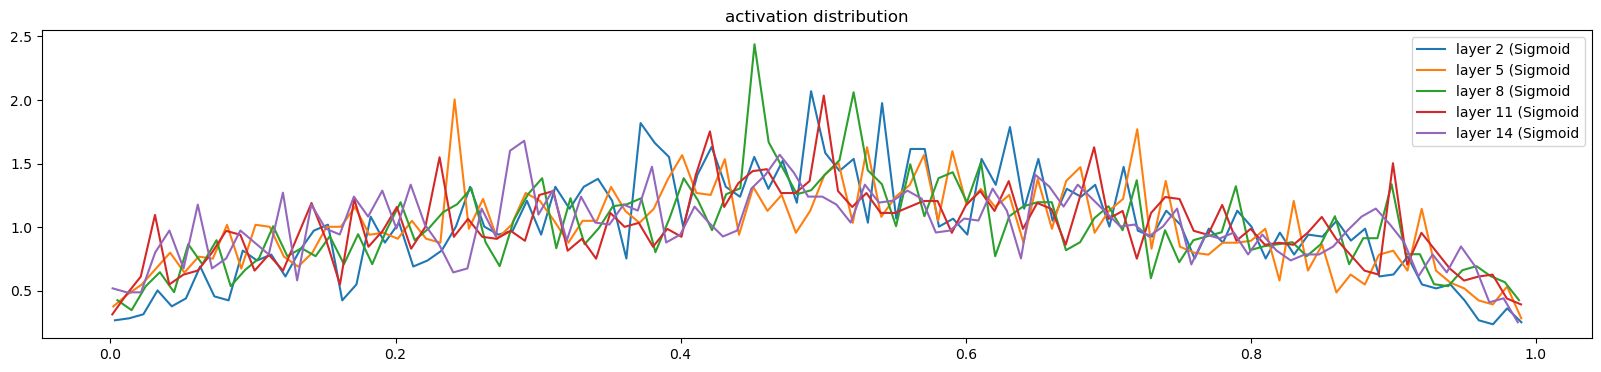

In [1220]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Sigmoid):
        t=layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated:%.2f%%' % (i,layer.__class__.__name__, t.mean(),t.std(),((t.abs()>0.97)|(t.abs()<0.03)).float().mean()*100))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution');
# thus we get low saturation as we go deeper in the layers 

layer 0 (    Linear): mean -0.37, std 6.25
layer 3 (    Linear): mean -0.29, std 5.55
layer 6 (    Linear): mean +0.21, std 5.46
layer 9 (    Linear): mean +1.08, std 5.69
layer 12 (    Linear): mean -0.21, std 6.29
layer 15 (    Linear): mean -0.60, std 5.19


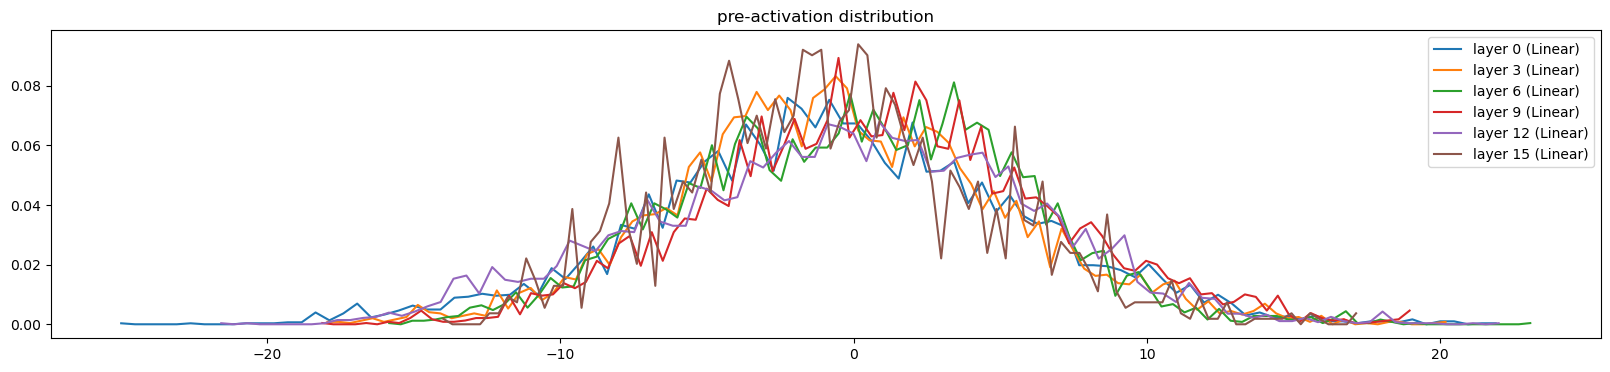

In [1221]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t=layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('pre-activation distribution');
# thus all pre activations have a simillar distribution indicating good training 

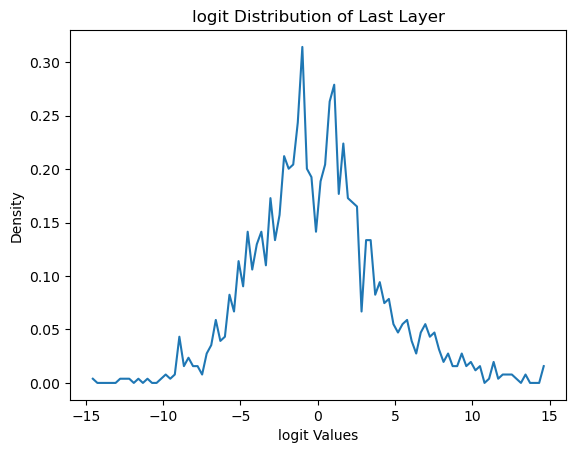

tensor(8.5468)


In [1222]:
l = layers[-1].out  
hy, hx = torch.histogram(l, density=True)  # Compute histogram
bin_centers = (hx[:-1] + hx[1:]) 
# Plot the histogram
plt.plot(bin_centers.detach(), hy.detach())
plt.xlabel('logit Values')
plt.ylabel('Density')
plt.title('logit Distribution of Last Layer')
plt.show()
print(bin_centers.detach().std())


saturation%:86.734375


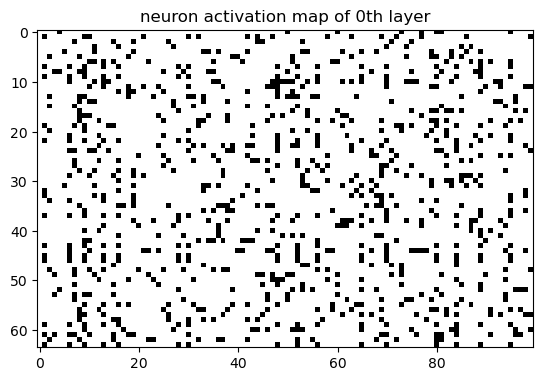

saturation%:39.796875


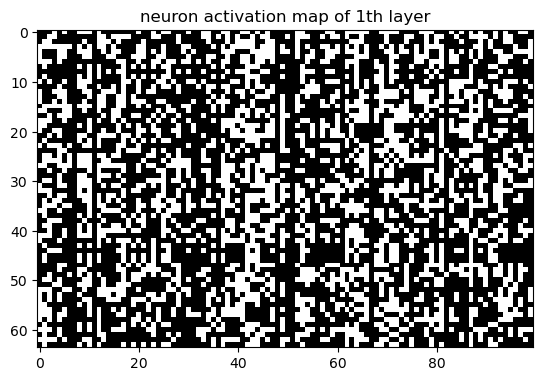

saturation%:0.8437500596046448


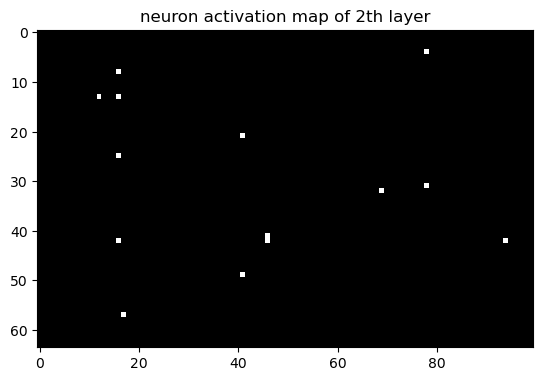

saturation%:85.859375


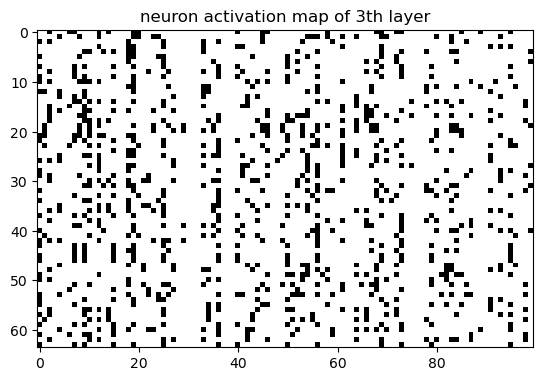

saturation%:45.15625


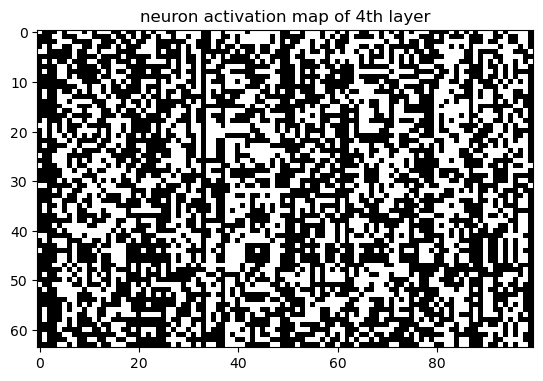

saturation%:1.203125


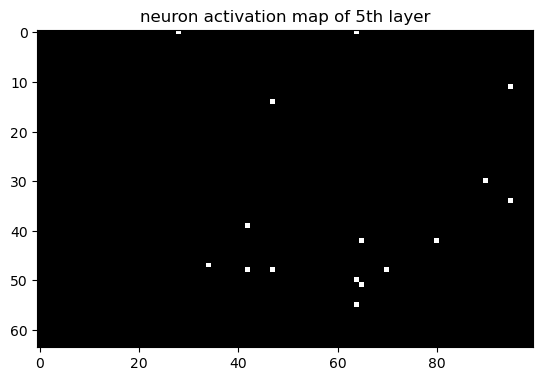

saturation%:87.234375


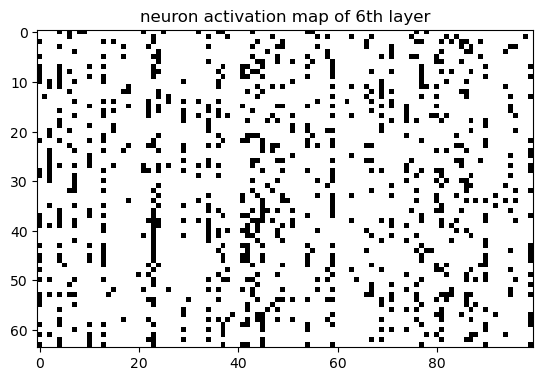

saturation%:44.640625


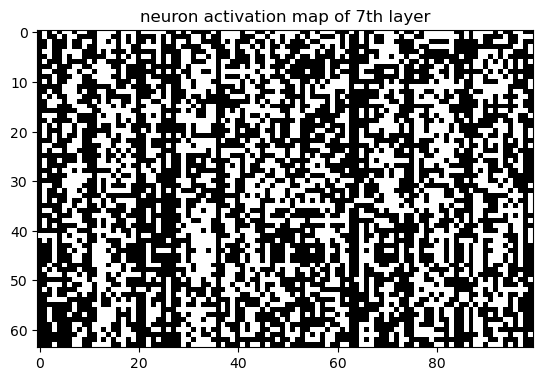

saturation%:1.375


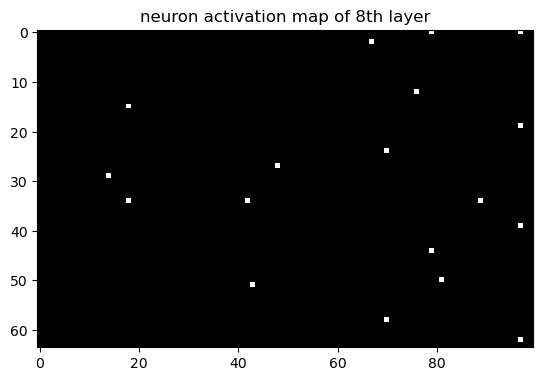

saturation%:86.453125


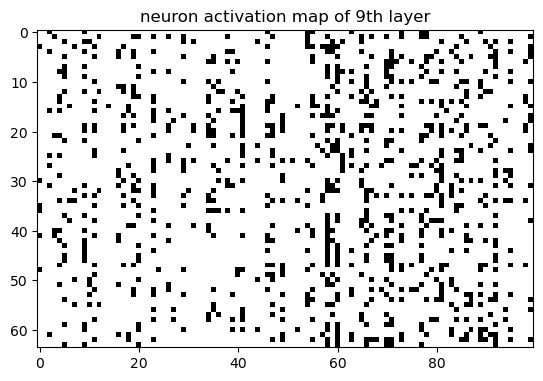

saturation%:47.109375


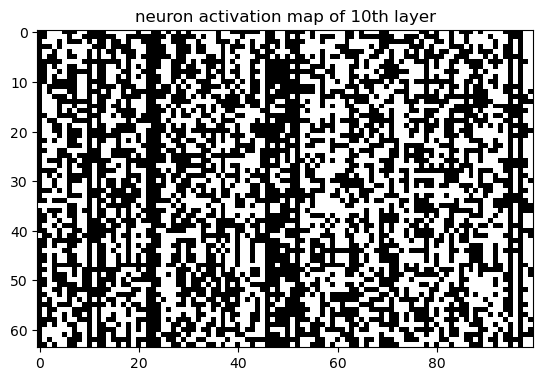

In [1223]:
for i in range(11):
    l = layers[i].out
    if i!=10:
        plt.imshow(l.abs()>0.99, cmap='gray',interpolation='nearest');
    else:
        plt.imshow((l.abs()>0.99) , cmap='gray',interpolation='nearest');
        
    print(f'saturation%:{((l.abs()>0.97).float().mean()*100)}')
    plt.title(f'neuron activation map of {i}th layer')
    plt.show()
# as we can see there is a level low saturation in the last layer 

tensor(0.0001)


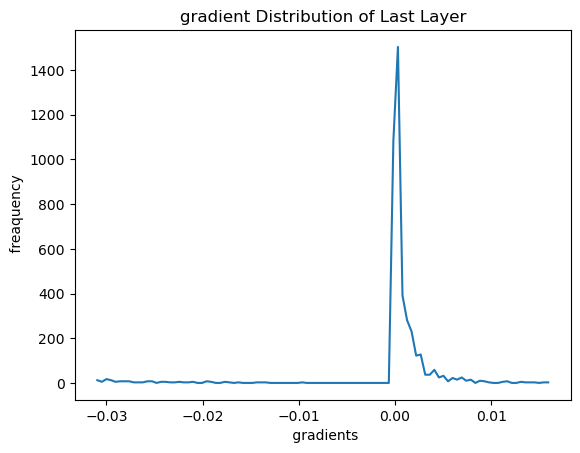

In [1224]:
l=layers[-1].out.grad
print(torch.median(l))
hy, hx = torch.histogram(l, density=True)  # Compute histogram
bin_centers = (hx[:-1] + hx[1:]) 
# Plot the histogram
plt.plot(bin_centers.detach(),hy.detach());
plt.xlabel(' gradients')
plt.ylabel(' freaquency')
plt.title('gradient Distribution of Last Layer')
plt.show()


layer 2 (   Sigmoid): mean -0.00, std 0.01
layer 5 (   Sigmoid): mean +0.00, std 0.01
layer 8 (   Sigmoid): mean -0.00, std 0.01
layer 11 (   Sigmoid): mean -0.00, std 0.01
layer 14 (   Sigmoid): mean -0.00, std 0.01


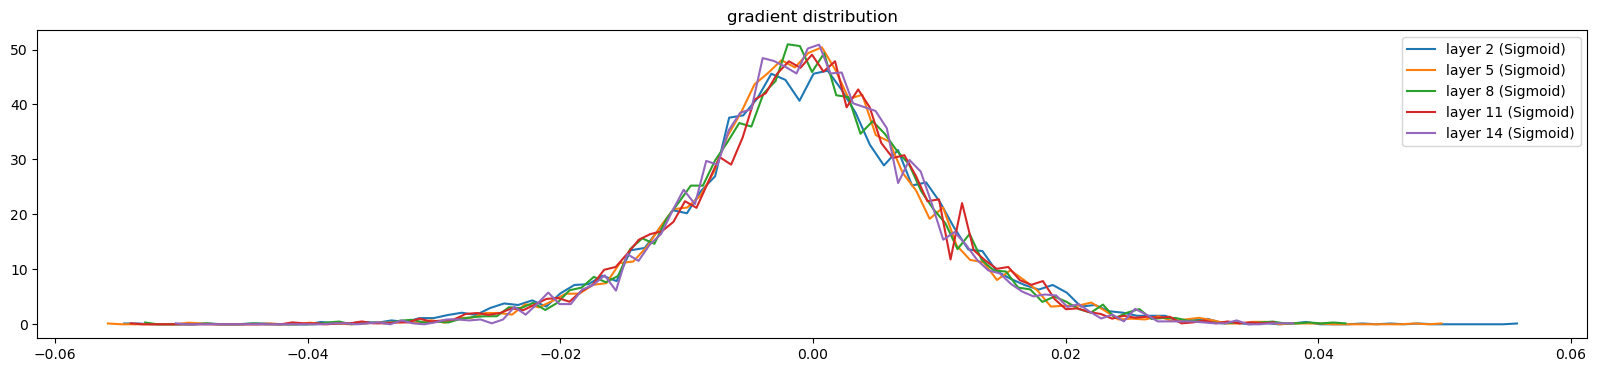

In [1225]:
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Sigmoid):
        t=layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution');


weights (  (27, 10)): mean -0.000000, std 1.127241e-02, grad:data ratio 1.078687e-02
weights ( (30, 100)): mean -0.000039, std 3.907901e-03, grad:data ratio 3.794909e-03
weights ((100, 100)): mean +0.000004, std 2.040771e-03, grad:data ratio 2.044604e-03
weights ((100, 100)): mean +0.000011, std 2.105477e-03, grad:data ratio 2.087349e-03
weights ((100, 100)): mean -0.000017, std 2.038265e-03, grad:data ratio 2.029061e-03
weights ((100, 100)): mean -0.000015, std 1.958566e-03, grad:data ratio 1.947977e-03
weights ( (100, 27)): mean +0.000060, std 3.544555e-03, grad:data ratio 3.568435e-03


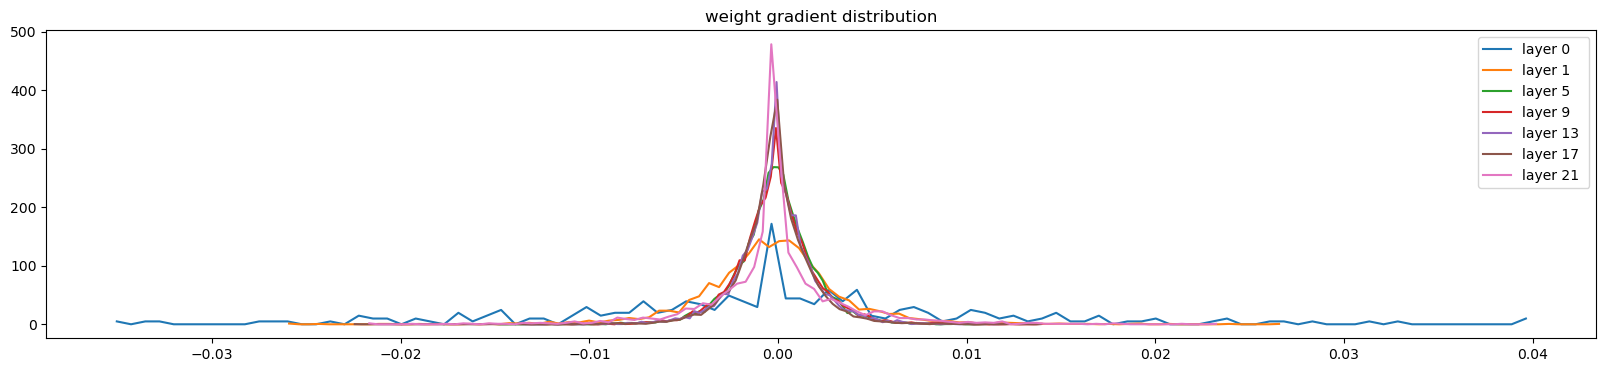

In [1226]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    t=p.grad
    if p.ndim==2:
        print('weights (%10s): mean %+f, std %e, grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ')
plt.legend(legends)
plt.title('weight gradient distribution');

 

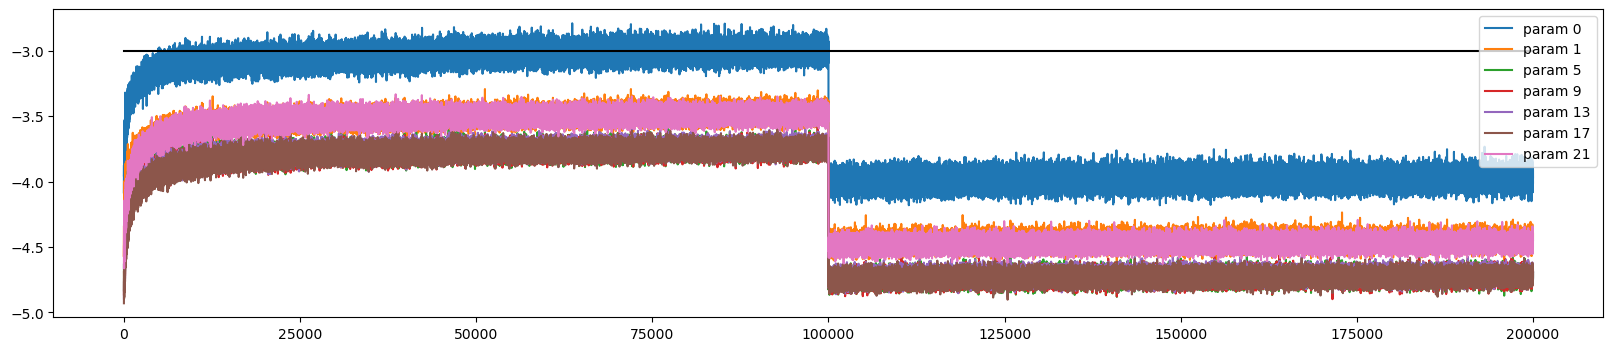

In [1227]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends)

In [1228]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(x_train,y_train),
        'val':(x_val,y_val),
        'test':(x_test,y_test)
        }[split]
    
    emb=C[x]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y)
    
    print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.1257834434509277
val 2.1561901569366455
test 2.1658310890197754


In [929]:
print('after fixing last layer initialization: train 2.137437343597412 val 2.184746265411377 test 2.180730104446411')
print('after fixing tanh saturation: train 1.9388813972473145 val 2.0883162021636963 test 2.0935585498809814')
print('after using BatchNorm: train 1.971767783164978 val 2.0737009048461914 test 2.076821804046631')
print('after using BatchNorm on sigmoid activation layer: train 2.1257834434509277 val 2.1561901569366455 test 2.1658310890197754')

after fixing last layer initialization: train 2.137437343597412 val 2.184746265411377 test 2.180730104446411
after fixing tanh saturation: train 1.9388813972473145 val 2.0883162021636963 test 2.0935585498809814
after using BatchNorm: train 1.971767783164978 val 2.0737009048461914 test 2.076821804046631
